# LSTM using TimeGenerator 

A more meaningful and complete example is given below that can be used as a black-box. Here we give multivariate, single step prediction with various look ahead

In [3]:
%load_ext autoreload
%autoreload 2

import os, datetime
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler
from IPython import display
from keras.preprocessing.sequence import TimeseriesGenerator
import IPython
from IPython.display import display

mpl.rcParams['figure.figsize'] = (16, 5)
mpl.rcParams['axes.grid'] = False

tf.random.set_seed(13)
pd.options.display.max_rows = 5

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# Read Data
#del dfn1
if ( "dfn1" not in globals()):
    csv_path = 'jena_climate_2009_2016.csv.zip'
    df = pd.read_csv(csv_path, nrows=100000)
    df['Date Time'] = pd.to_datetime( df['Date Time'] )

    dfn1= df[['T (degC)']].copy()
    dfn1.index = df['Date Time']

    dfn2= df[['T (degC)', 'p (mbar)', 'rho (g/m**3)']].copy()
    dfn2.index = df['Date Time']

    dfn = dfn2
    dfn
    
dfn2

,T (degC),p (mbar),rho (g/m**3)
Date Time,,,
2009-01-01 00:10:00,-8.02,996.52,1307.75
2009-01-01 00:20:00,-8.41,996.57,1309.80
...,...,...,...
2010-11-25 10:50:00,1.10,977.82,1239.34
2010-11-25 11:00:00,1.13,977.71,1239.05


# Data

Review the data carefully. It has 100k rows, readings taken for every 10 minutes; we chose 3 features (it can be one). We want to look back 720 readings back (in a day we have 24 * 6 = 144 readings, we sample every 6th, reading, therefore, we must have 120 time-steps x 3 features) and predict the temperature one hour ahead i.e. 10 readings ahead) 

Notice we carefully chose one hour ahead prediction because, it aligns well with sampling_rate of 6.
If we wanted to predict two hours ahead, we cannot use sampling_rate, because it affects both X and y. 
In this case we must adjust labels correctly.

Similarly if we wanted multistep, then we must prepare y appropriately.

In [5]:
class TargetGen(object):
    def __init__(self, targets, nsteps=1):
        self.targets = targets
        self.nsteps  = nsteps
        
    def __len__(self):
        return len(self.targets[:-self.nsteps+1 or None])

    def getData(self, index):
        t = self.targets[index: index + self.nsteps]
        return t

    def __getitem__( self, key ) :
        
        if isinstance( key, int) or isinstance( key, int) or isinstance(key, np.int64 ):
            if key < 0: 
                key += len(self)
            if key < 0 or key >= len( self ) :
                raise (IndexError, f"The index (key) is out of range. {len(slef)}")
            return self.getData(key)
        if isinstance( key, slice ) :
            return [self.targets[ii: ii + self.nsteps] for ii in range(*key.indices(len(self)))]
        else:
            raise (TypeError, "Invalid argument type.")
    

In [6]:
def makestep(a, start, steps=5):
    o= []
    for i in range(steps):
        a1 = a[start+i:-steps+i+1 or None]
        o.append(a1)
    
    return np.hstack([o]).T

def makestepTS(a, start, steps=5):
    g = TargetGen(a[start:], steps)
    return g

data=dfn2.values[0:10]
g=makestepTS(data,0,5)
for i in range(len(g)):
    y = g[i]
    y1 = [f'{str(list(k)):25}' for k in y]
    print(f'=>{y1}')
print(data)


=>['[-8.02, 996.52, 1307.75] ', '[-8.41, 996.57, 1309.8]  ', '[-8.51, 996.53, 1310.24] ', '[-8.31, 996.51, 1309.19] ', '[-8.27, 996.51, 1309.0]  ']
=>['[-8.41, 996.57, 1309.8]  ', '[-8.51, 996.53, 1310.24] ', '[-8.31, 996.51, 1309.19] ', '[-8.27, 996.51, 1309.0]  ', '[-8.05, 996.5, 1307.86]  ']
=>['[-8.51, 996.53, 1310.24] ', '[-8.31, 996.51, 1309.19] ', '[-8.27, 996.51, 1309.0]  ', '[-8.05, 996.5, 1307.86]  ', '[-7.62, 996.5, 1305.68]  ']
=>['[-8.31, 996.51, 1309.19] ', '[-8.27, 996.51, 1309.0]  ', '[-8.05, 996.5, 1307.86]  ', '[-7.62, 996.5, 1305.68]  ', '[-7.62, 996.5, 1305.69]  ']
=>['[-8.27, 996.51, 1309.0]  ', '[-8.05, 996.5, 1307.86]  ', '[-7.62, 996.5, 1305.68]  ', '[-7.62, 996.5, 1305.69]  ', '[-7.91, 996.5, 1307.17]  ']
=>['[-8.05, 996.5, 1307.86]  ', '[-7.62, 996.5, 1305.68]  ', '[-7.62, 996.5, 1305.69]  ', '[-7.91, 996.5, 1307.17]  ', '[-8.43, 996.53, 1309.85] ']
[[  -8.02  996.52 1307.75]
 [  -8.41  996.57 1309.8 ]
 [  -8.51  996.53 1310.24]
 [  -8.31  996.51 1309.19]
 [  

In [7]:
''' This just builds a model 
Optimizeers
opt1 = tf.keras.optimizers.RMSprop(clipvalue=1.0)
 
 inshape = input shape => #time_steps x #features
'''
import keras

def lstmmodel(inps, inshape, units2=None, nsteps=1, opt="adam", loss="mse", bi=False, dropout=None):
    s= inshape
    print(locals())
    print(f"Creating LSTM: inuts= {inps} time-steps: {s[0]}, features: {s[1]} #out: {nsteps}")
    m = keras.models.Sequential()

    if (bi):
        m.add(keras.layers.Bidirectional(
            keras.layers.LSTM(inps, return_sequences= (units2 is not None), input_shape=s) ) )
    else:
        m.add(keras.layers.LSTM(inps, return_sequences= (units2 is not None), input_shape=s) )
    
    if(units2 is not None): #Lets just keep it simple for 2 layers only
        m.add(keras.layers.LSTM(units2, activation='relu'))
    if (dropout is not None):
        m.add( keras.layers.Dropout(dropout) )
    m.add(keras.layers.Dense(nsteps))
    m.compile(optimizer = opt, loss= loss)
    return m

def Plot_(y, h, x=None, title=None,**kwargs):
    #x = x if x is not None else range(len(y))
    plt.plot(y[:,0], marker=".", label = "y")

    if ( len(h.shape) <= 1):
        h = h.reshape((len(h), 1))
    for i in range(h.shape[-1]):
        uy=h[i:,i]
        plt.plot(range(i, len(uy)+i), uy, marker="x",  label = f"$h_{i}$")

    plt.title(title)
    plt.grid(b="on")
    plt.legend()
    return y1, h1;

def modelEqual(m1, m2):
    ok = len(m1.layers) ==  len(m2.layers)
    if (not ok):
        return ok

    for l1, l2 in zip(m1.layers, m.layers):
        c1, c2 = l1.get_config(), l2.get_config()
        tn = c1['name'] 
        c1['name'] = c2['name'] 
        ok = c1 == c2 
        c1['name'] = tn
        if (not ok):
            break;
    return ok


'''
NEW NeuealNetwork Class to manage LSTM
'''
class NNmodel:
    def __init__(self, tsParams, model, file=None,  nsteps=1, loadModel=True):
        defp =  { 
                    "length":         20,
                    "batch_size":     256,
                    "stride":         1,
                    "sampling_rate" : 1
                }
        self.model = m
        self.tsParam = tsParams or defp
        
        if( file is not None):
            self.model_file=file;
            #Load the file and other parameters 
            if (loadModel and os.path.exists(file)):
                m1=self.load()
                if modelEqual(m,m1) or m is None:
                    m.set_weights(m1.get_weights()) 
                    print(f"Using the loaded model {file}!!")
                else:
                    print("Models are different, ignoring model loaded from file")
        
        self.nsteps= nsteps # nstep predictions
    
    def setvals(self, d: dict):
        for k, v in d.items():
            setattr(self, k, v)

    def save(self, file = None):
        model_file = file or self.model_file
        self.model.save(model_file)

    def load(self, file = None):
        model_file = file or self.model_file
        m = load_model(model_file)
        return m

    def dump(self):
        vr = vars(nnmodel)
        for k,v in vr.items():
            if type(v) == pd.core.frame.DataFrame:
                print(f'{k}: shape:{v.shape}')
            else:
                print(f'{k}, {type(v)}: {v}')
                
    # First, do preprocessing which consists of:
    # 1. Remove time correlated variables
    # 2. Add a time cycle if it makes sense, Suppose a event occurs based on time, then we must have that cycle
    # 3. Normalize the data

    # *NOTE* we scale only on the training data - *NOT* on the entire dataset
    #
    def prepare(self, dfn2, pct=0.8, lables=None, lableIndex=0):
        data = dfn2
        if ( type(dfn2) == pd.core.frame.DataFrame):
            data = dfn2.values
        
        trni = int(len(data) * pct) if (pct < 1) else pct

        scaler = StandardScaler()
        dfs = scaler.fit(data[:trni])
        dfs.mean_, dfs.scale_
        dfscaled = (data-dfs.mean_)/dfs.scale_

        lables     = lables if lables is not None else dfscaled[:,lableIndex]
        #lables     = makestep(lables, 0, self.nsteps)
        lables     = makestepTS(lables, 0, self.nsteps)
        dfscaled   = dfscaled[:len(lables)]
        
        trnX, trnY = dfscaled[:trni], lables[:trni]
        valX, valY = dfscaled[trni:], lables[trni:]

        print(f"#Training: {trni} samples, Test: {len(valY), len(valX)} samples!")
        
        trng    = TimeseriesGenerator(trnX, trnY, **self.tsParam )
        valg    = TimeseriesGenerator(valX, valY, **self.tsParam )
        
        #dfns is the scaled data
        self.dfscaled, self.lables, self.lableIndex = dfscaled, lables, lableIndex
        self.df, self.trng, self.valg, self.scaler = dfn2, trng,valg, scaler 
        
        return self.dfscaled, self.trng, self.valg, self.scaler 
               

    #We can be snart to add additional new training - not now though
    def fit(self,epochs=1, trn=None, val=None):
        assert hasattr( self, "trng"), "You must call prepapre!!!"
            
        if (trn is None or val is None):
            trn,val = self.trng, self.valg
            
        for i in range(epochs):
            self.model.fit(trn, verbose=1, epochs=1, validation_data=val, steps_per_epoch=200, 
                          validation_steps=50, workers=4, use_multiprocessing=True)
   
    #Predictions within the traning or valiadation dataset
    #
    def predict(self, start=0, howmany=100, scaleout=True, title=""):
        scaler = self.scaler
        tsParams = self.tsParam.copy()
        tsParams['batch_size'] = howmany;
        
        data   = self.dfscaled[start:]
        lables = self.lables[start:]
        g      = TimeseriesGenerator(data, lables, **tsParams )
        
        ##
        model = self.model
        x, y = g[0]
        h = model.predict(x)
        h1, y1 = h,y
        if (scaleout):
            h1 = h * scaler.scale_[self.lableIndex]
            h1 = h1  + scaler.mean_[self.lableIndex]

            y1 = y * scaler.scale_[self.lableIndex]
            y1 = y1  + scaler.mean_[self.lableIndex]

        return y1, h1

    #This is for predicting new data
    def prepForPredict(self, dfn2, start=0, howmany=100, lables=None, scaleout=True, title=""):
        scaler = self.scaler
        tsParams = self.tsParam.copy()
        tsParams['batch_size'] = howmany;
        
        data = dfn2
        if ( type(dfn2) == pd.core.frame.DataFrame):
            data = dfn2.values
        
        data   =  (data - scaler.mean_)/scaler.scale_
        lables = lables if lables is not None else data[:,self.lableIndex]
        lables = makestepTS(lables, 0, self.nsteps)
        data   = data[:len(lables)]
        
        g   = TimeseriesGenerator(dfscaled[start:], lables[start:], **tsParams )
        
        ##
        model = self.model
        x, y = g[0]
        h = model.predict(x)
        h1, y1 = h,y
        if (scaleout):
            h1 = h * scaler.scale_[self.lableIndex]
            h1 = h1  + scaler.mean_[self.lableIndex]

            y1 = y * scaler.scale_[self.lableIndex]
            y1 = y1  + scaler.mean_[self.lableIndex]

        return y1, h1


In [8]:
#Some test to check the timeSeries Generator
tsParams={ 
    "length":         3,
    "batch_size":     2,
    "stride":         1,
    "sampling_rate" : 1
}

m = None # WE dont care for testing anyway
nnmodel1 = NNmodel(tsParams=tsParams, model=m, nsteps=2)
data=dfn2.values[0:10]

dfscaled, trng, valg, scaler = nnmodel1.prepare(data, pct=.5)
dfscaled

#Training: 5 samples, Test: (4, 4) samples!


array([[ 1.72504983, -0.3592106 , -1.70789837],
       [-0.64385663,  1.88585567,  0.713396  ],
       [-1.25126854,  0.08980265,  1.23308845],
       [-0.03644471, -0.80822386, -0.00708672],
       [ 0.20652005, -0.80822386, -0.23149936],
       [ 1.54282626, -1.25723711, -1.57797526],
       [ 4.15469749, -1.25723711, -4.15281513],
       [ 4.15469749, -1.25723711, -4.14100393],
       [ 2.39320294, -1.25723711, -2.39294751]])

In [9]:
for i in range(len(trng)):
    x,y = trng[i]
    print(f'{x} ==>\n\t\t\t\t\n {y}')
print("\n===========Validation set\n")    
for i in range(len(valg)):
    x,y = valg[i]
    print(f'{x} ==>\n\t\t\t\t {y}')

3
4
[[[ 1.72504983 -0.3592106  -1.70789837]
  [-0.64385663  1.88585567  0.713396  ]
  [-1.25126854  0.08980265  1.23308845]]

 [[-0.64385663  1.88585567  0.713396  ]
  [-1.25126854  0.08980265  1.23308845]
  [-0.03644471 -0.80822386 -0.00708672]]] ==>
				
 [[-0.03644471  0.20652005]
 [ 0.20652005  1.54282626]]

===========Validation set

3
[[[ 1.54282626 -1.25723711 -1.57797526]
  [ 4.15469749 -1.25723711 -4.15281513]
  [ 4.15469749 -1.25723711 -4.14100393]]] ==>
				 [[ 2.39320294 -0.76533901]]


In [10]:
nnmodel1.dfscaled[0:]

array([[ 1.72504983, -0.3592106 , -1.70789837],
       [-0.64385663,  1.88585567,  0.713396  ],
       [-1.25126854,  0.08980265,  1.23308845],
       [-0.03644471, -0.80822386, -0.00708672],
       [ 0.20652005, -0.80822386, -0.23149936],
       [ 1.54282626, -1.25723711, -1.57797526],
       [ 4.15469749, -1.25723711, -4.15281513],
       [ 4.15469749, -1.25723711, -4.14100393],
       [ 2.39320294, -1.25723711, -2.39294751]])

{'inps': 32, 'inshape': (20, 1), 'units2': None, 'nsteps': 1, 'opt': 'adam', 'loss': 'mse', 'bi': False, 'dropout': None, 's': (20, 1)}
Creating LSTM: inuts= 32 time-steps: 20, features: 1 #out: 1
Using the loaded model m1.h5!!
#Training: 80000 samples, Test: (20000, 20000) samples!
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119


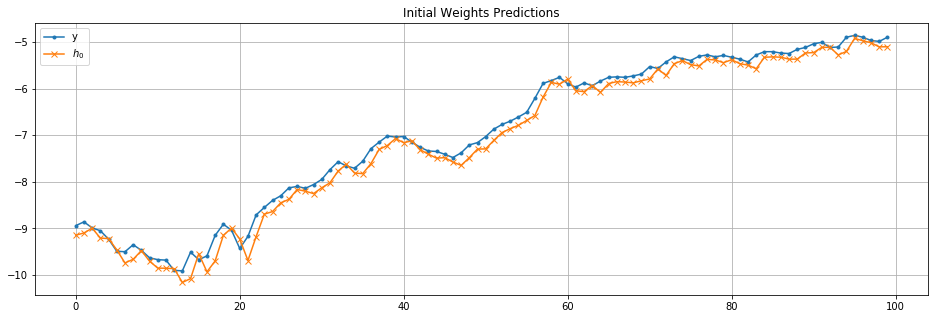

In [11]:
# All steps reusing the functions 
# Step 1. Read Data here
#Lets review the generator output
tsParams={ 
    "length":         20,
    "batch_size":     256,
    "stride":         1,
    "sampling_rate" : 1
}

m = lstmmodel(32, (20,1), units2=None, nsteps=1, opt="adam", loss="mse" )
nnmodel1 = NNmodel(tsParams=tsParams, model=m, file="m1.h5")
nnmodel1.prepare(dfn1, pct=80000)

y1, h1 = nnmodel1.predict(0, 100)
o= Plot_(y1, h1, title="Initial Weights Predictions")


In [ ]:
epochs=10
for i in range(epochs):
    plt.clf()  
    y1, h1 = nnmodel1.predict(start=10000, howmany=100)
    Plot_( y1, h1, title=f"{i}")
    plt.show()
    nnmodel1.fit()
    IPython.display.clear_output(wait=True)
    #IPython.display.display(plt.gcf())

nnmodel1.save()

# Sampling Rate and Stride

Just inspect what are the values set 

In [ ]:
# Sanity Check to make sure everything is aligned
tsParams={ 
    "length":         720,
    "batch_size":     256,
    "stride":         1,
    "sampling_rate" : 6
}
data   = dfn2.values
labels = data[:,0]
g = TimeseriesGenerator(data, labels, **tsParams )

#Lets review the generator output
x, y = g[0]    
print(f'{x.shape}, {y.shape} {y[0]}')
print(f'X: \n{x[0][-3:]} <= should match every 6th entry\n Also: \n{y[0]} <= 720th entry')

In [ ]:
# Sanity Check to visually check if X and y correctly aligned
# Whenever you see "<=" mark, it is aligned at sampling rate of 6

dfn3= dfn2.copy()
dfn3['idx'] = [i if i % 6 != 0 else f'<={i}' for i in range(len(dfn3))]
display(dfn3[700:724])
del dfn3

# Multivariate Predictions

In [ ]:
#Lets build a model with multiple features

# All steps reusing the functions 
# Step 1. Read Data here
#Lets review the generator output
tsParams={ 
    "length":         720,
    "batch_size":     256,
    "stride":         1,
    "sampling_rate" : 6
}


m = lstmmodel(32, (120,3), units2=None, nsteps=1, opt="adam", loss="mse" )
nnmodel1f = NNmodel(tsParams=tsParams, model=m, file="m3.h5")
nnmodel1f.prepare(dfn2, pct=80000)

y1, h1 = nnmodel1f.predict(0, 100)
o=Plot_(y1, h1, title="Initial Weights Predictions")


In [ ]:
epochs= 4
for i in range(epochs):
    plt.clf()  
    y1, h1 = nnmodel1f.predict(0, 100)
    Plot_( y1, h1, title=f"{i}")
    plt.show()
    nnmodel1f.fit()
    IPython.display.clear_output(wait=True)
    #IPython.display.display(plt.gcf())
nnmodel1f.save()

# Compare the performance with one feature

In [ ]:
#Lets try sampling rate with one feature

# All steps reusing the functions 
# Step 1. Read Data here
#Lets review the generator output
tsParams={ 
    "length":         720,
    "batch_size":     256,
    "stride":         1,
    "sampling_rate" : 6
}

m = lstmmodel(32, (120,1), units2=None, nsteps=1, opt="adam", loss="mse" )
nnmodel1s = NNmodel(tsParams=tsParams, model=m, file="m3-1.h5")
nnmodel1s.prepare(dfn1, pct=80000)

y1, h1 = nnmodel1s.predict(0, 100)
o=Plot_(y1, h1, title="Initial Weights Predictions: sample every 6th")

In [ ]:
epochs=5
for i in range(epochs):
    plt.clf()  
    y1, h1 = nnmodel1s.predict(0, 100)
    Plot_( y1, h1, title=f"{i}")
    plt.show()
    nnmodel1s.fit()
    IPython.display.clear_output(wait=True)
    #IPython.display.display(plt.gcf())

nnmodel1s.save()

In [ ]:
s,h = 95000, 100
y1, h1 = nnmodel1s.predict(s,h)
Plot_( y1, h1, title=f"{s}-{h}");

***
# MultiVariate Multiple Step Predictions

TimeseriesGenerator dont have mechanisms to generate multistep out, we need to prepare the data set as such.

In [ ]:
#Example Uage of makesteps
a=list(range(10))
k=makestep(a, 5, 3)
a, k.shape, k

In [ ]:
#Lets build a model with multiple features

# All steps reusing the functions 
# Step 1. Read Data here
#Lets review the generator output
tsParams={ 
    "length":         720,
    "batch_size":     256,
    "stride":         1,
    "sampling_rate" : 6
}

nsteps = 5 # 5 predictions

opt = tf.keras.optimizers.Adam(lr=0.0001, clipnorm=1.0, clipvalue=0.5)
m = lstmmodel(32, (120,3), units2=32, nsteps=nsteps, opt=opt, loss="mse", dropout=0.5 )
nnmodel1mf = NNmodel(tsParams=tsParams, model=m, nsteps=nsteps, file="m3-step-5.h5", loadModel=True)
nnmodel1mf.prepare(dfn2, pct=80000)

y1,h1 = nnmodel1mf.predict(0, 100, scaleout=True)
#o=Plot_(y1, h1, title="Initial Weights Predictions-multistep")
o=Plot_(y1, h1, title="Initial Weights Predictions: sample every 6th")


In [ ]:
epochs=4
for i in range(epochs):
    plt.clf()  
    y1,h1 = nnmodel1mf.predict(0, 100)
    Plot_( y1, h1, title=f"{i}")
    plt.show()
    nnmodel1mf.fit(epochs=10)
    IPython.display.clear_output(wait=True)
    #IPython.display.display(plt.gcf())

nnmodel1mf.save();

# Some explorations

In [ ]:
m=nnmodel1mf.model

keras.engine.sequential.Sequential.summary(m)

In [ ]:
m.get_input_shape_at(0), m.get_output_shape_at(0)
for i in range(len(m.layers)):
    l = m.layers[i]
    s = l.get_input_shape_at(0)
    o = l.get_output_shape_at(0)
    print(f'{i}=> inp shape: {str(s):15}, out shape: {o}')

l.get_output_shape_at(0)

In [ ]:
l=m.layers[0]

In [ ]:
for i in range(len(l.get_weights())):
    print(l.get_weights()[i].shape)

In [ ]:
3 *128 + 32 *128 + 128